・Directory Structure

./

 -- epoch_images/
 
 -- gan_practice.ipynb

# environmental setting

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
!ls
%cd './drive/MyDrive/'Colab Notebooks'/GAN_session'
!ls

In [ ]:
from tensorflow.python.client import device_lib
import tensorflow as tf

In [ ]:
device_lib.list_local_devices()

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
        print('{} memory growth: {}'.format(device, tf.config.experimental.get_memory_growth(device)))
else:
    print("Not enough GPU hardware devices available")

#  **GAN** (CIFAR-10)


In [ ]:
from __future__ import print_function, division

import tensorflow as tf

from tensorflow.keras.datasets import cifar10

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, UpSampling2D, Conv2D, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import cv2
import matplotlib.pyplot as plt
import sys
import numpy as np

In [ ]:
class Discriminator(Model):
    def __init__(self):
        img_rows = 32
        img_cols = 32
        channels = 3
        img_shape = (img_rows, img_cols, channels)
        self.latent_dim = 100

        super(Discriminator, self).__init__()
        self.flatten = Flatten(input_shape=img_shape)
        self.d1 = Dense(512)
        self.lrelu1 = LeakyReLU(alpha=0.2)
        self.d2 = Dense(256)
        self.lrelu2 = LeakyReLU(alpha=0.2)
        self.d3 = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.flatten(x)
        x = self.d1(x)
        x = self.lrelu1(x)
        x = self.d2(x)
        x = self.lrelu2(x)
        valid = self.d3(x)
        return valid

In [ ]:
class Generator(Model):
    def __init__(self):
        img_rows = 32
        img_cols = 32
        channels = 3
        img_shape = (img_rows, img_cols, channels)
        self.latent_dim = 100

        super(Generator, self).__init__()
        self.d1 = Dense(256)
        self.lrelu1 = LeakyReLU(alpha=0.2)
        self.bn1 = BatchNormalization(momentum=0.8)
        self.d2 = Dense(512)
        self.lrelu2 = LeakyReLU(alpha=0.2)
        self.bn2 = BatchNormalization(momentum=0.8)   
        self.d3 = Dense(1024)
        self.lrelu3 = LeakyReLU(alpha=0.2)
        self.bn3 = BatchNormalization(momentum=0.8)
        self.d4 = Dense(np.prod(img_shape), activation='tanh')
        self.reshape = Reshape(img_shape)

    def call(self, x):
        x = self.d1(x)
        x = self.lrelu1(x)
        x = self.bn1(x)
        x = self.d2(x)
        x = self.lrelu2(x)
        x = self.bn2(x)
        x = self.d3(x)
        x = self.lrelu3(x)
        x = self.bn3(x)
        x = self.d4(x)
        img = self.reshape(x)
        return img

In [ ]:
class GAN():
    def __init__(self):
        self.latent_dim = 100

        self.d_loss = tf.keras.losses.BinaryCrossentropy(name='d_train_loss')
        self.d_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='d_accuracy')
        self.g_loss = tf.keras.losses.BinaryCrossentropy(name='g_train_loss')
        self.optimizer = Adam(0.0002, 0.5)

        self.discriminator = Discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=self.optimizer,
            metrics=['accuracy'])
        
        self.generator = Generator()
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        self.discriminator.trainable = False
        validity = self.discriminator(img)
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=self.optimizer)

        self.fixed_noise = np.random.normal(0, 1, (12, self.latent_dim))

    def combine_images(self, gen_imgs, epoch, idx, iterations):
        r, c = 4, 3
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        fig.subplots_adjust(wspace=0.1, hspace=0.1)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("./epoch_images_cifar/epoch_%d_iter_%d"%(epoch+1, idx+1), bbox_inches='tight')
        plt.close()

    def train(self, epochs, batch_size=128):
        (X_train, _y_train_full), (_X_test, _y_test) = cifar10.load_data()
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        self.e = [10]
        self.d_acc = [10]
        self.g_los = [10]

        # 50,000/32
        iterations = X_train.shape[0]/batch_size
        
        for epoch in range(epochs):
            for idx in range(int(iterations)-1):
                # Select a random half of images
                imgs = X_train[idx*batch_size : (idx+1)*batch_size]

                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                gen_imgs = self.generator.predict(noise)

                d_loss_real = self.discriminator.train_on_batch(imgs, valid)
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                g_loss = self.combined.train_on_batch(noise, valid)
                
                if (iterations*epoch+idx+1) % 1000 == 0:
                    self.e.append(epoch)
                    self.d_acc.append(100*d_loss[1])
                    self.g_los.append(g_loss)

            print ("%d [epoch : %d, D loss: %f, acc.: %.2f%%] [G loss: %f]"% (iterations*epoch+idx+1, epoch, d_loss[0], 100*d_loss[1], g_loss))
            gen_imgs = self.generator.predict(self.fixed_noise)
            gen_img = self.combine_images(gen_imgs, epoch, idx, iterations)

In [ ]:
gan = GAN()
gan.train(epochs=30, batch_size=32)

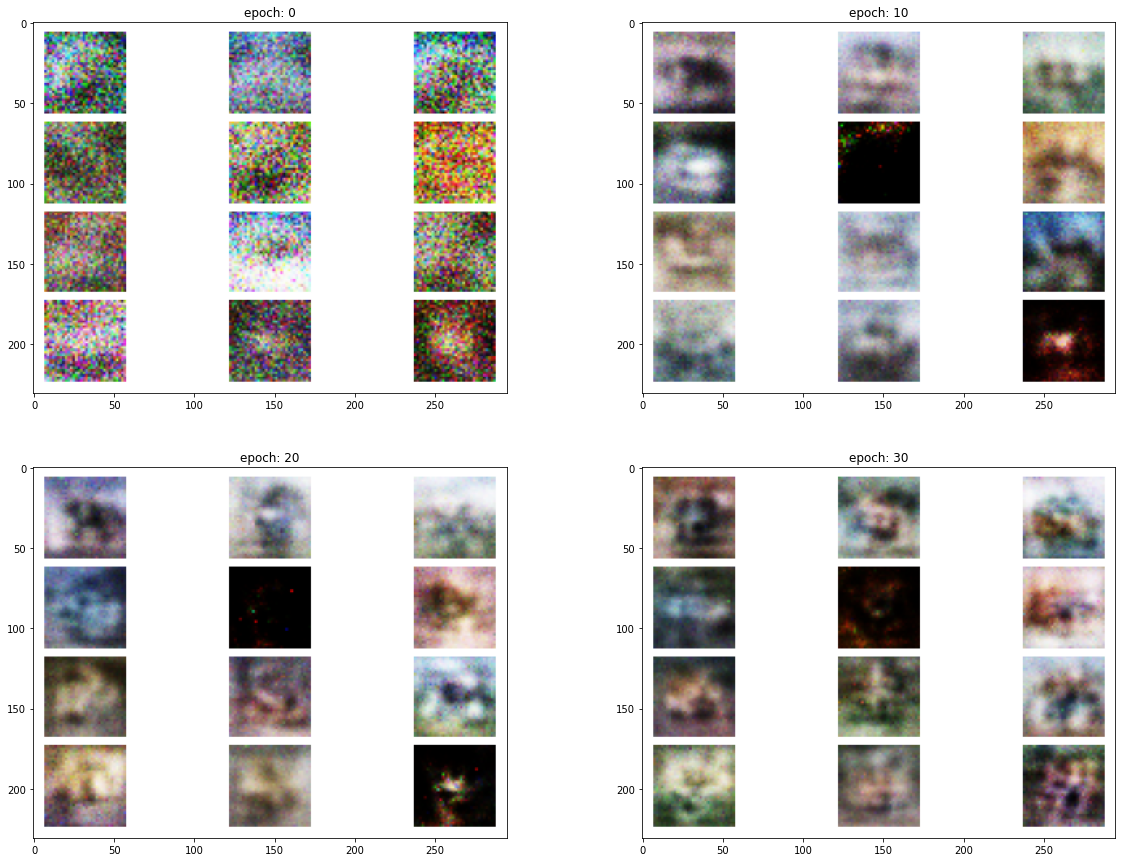

In [ ]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(2, 2, 1, title="epoch: 0")
img = cv2.imread("epoch_images_cifar/epoch_1_iter_1561.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #BGRをRGBに変換.
ax.imshow(img)
ax = fig.add_subplot(2, 2, 2, title="epoch: 10")
img = cv2.imread("epoch_images_cifar/epoch_10_iter_1561.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #BGRをRGBに変換.
ax.imshow(img)
ax = fig.add_subplot(2, 2, 3, title="epoch: 20")
img = cv2.imread("epoch_images_cifar/epoch_20_iter_1561.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #BGRをRGBに変換.
ax.imshow(img)
ax = fig.add_subplot(2, 2, 4, title="epoch: 30")
img = cv2.imread("epoch_images_cifar/epoch_30_iter_1561.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #BGRをRGBに変換.
ax.imshow(img)